In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering import *
from gensim.models import Word2Vec
import umap
import hdbscan

In [7]:
data_small = "data/small_df/cleaned_small.csv"
data_avg = "data/average_df/cleaned_avg.csv"
data_tot = "data/total_df/cleaned_tot.csv"

df = pd.read_csv(data_tot)

## Word2Vec

This algorithm is a group of machine learning architectures that can find words with similar contexts (group of words that surrounds a given word in a sentence or a document) and group them together.

This grouping, also known as word embeddings, results in a cluster of vectors that have similar meanings. The vectors representing words with similar meanings are positioned close to each other in this high-dimensional space.

The Vectorization for each document is done by averaging the word's vectors.

In [8]:
corpus = df["cleaned_corpus"].tolist()
custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

custom_stopwords = [word.lower() for word in custom_stopwords]
corpus_cleaned = [delete_stopwords(text, custom_stopwords) for text in corpus]
corpus_cleaned = [patent.split() for patent in corpus_cleaned]

In [ ]:
# min_count : number of occurences for the word to be counted
# We use CBOW
word2vec_model = Word2Vec(sentences=corpus_cleaned, vector_size=700, min_count = 2, workers=4, window=15)

In [10]:
X_word2vec = vectorize_word2vec(corpus_cleaned, word2vec_model)
len(X_word2vec), len(X_word2vec[0])

(100001, 700)

## K-Means Clustering

### Number of clusters: Elbow Method

This method involves finding the optimal K via graphical representation. It finds the within cluster sum of squares (WCSS), i.e. the sum of the square distance between points in a cluster and the cluster centroid. 

If the plotting of the WCSS over the number of clusters represents an elbow, then we pick the K-value where the elbow gets created. Beyond the elbow point, increasing the value of 'K' does not lead to a significant reduction in WCSS. 

Here we test for k from 2 to 50. 

In [11]:
#elbow_scores = elbow_method(X_word2vec, 50)

### Number of clusters: Silhouette Method

The value of the Silhouette score ranges from -1 to 1:

- 1: Points are perfectly assigned in a cluster and clusters are easily distinguishable.
- 0: Clusters are overlapping.
- -1: Points are wrongly assigned in a cluster.

It is computed as follows:
$$
Silhouette Score = \frac{b-a}{max(a, b)}
$$

- a is the average <ins>intra-cluster</ins> distance, i.e the average distance between each point within a cluster.
- b is the average <ins>inter-cluster</ins> distance i.e the average distance between all clusters.


It seems the silhouette method confirms K = 37 too. 

In [12]:
#optimal_k, silhouette_scores = compute_silhouette_method(X_word2vec, 15)

### K-Means

Based on the previous results, we compute K-Means with K = 15. 

We can see from the results that the clusters are not visually clear, and one of them contains a large amount of data. Would be important to also verify wether the smaller ones contain the outliers in terms of number of words within the corpus. 

K-Means converged in 268 iterations.


/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


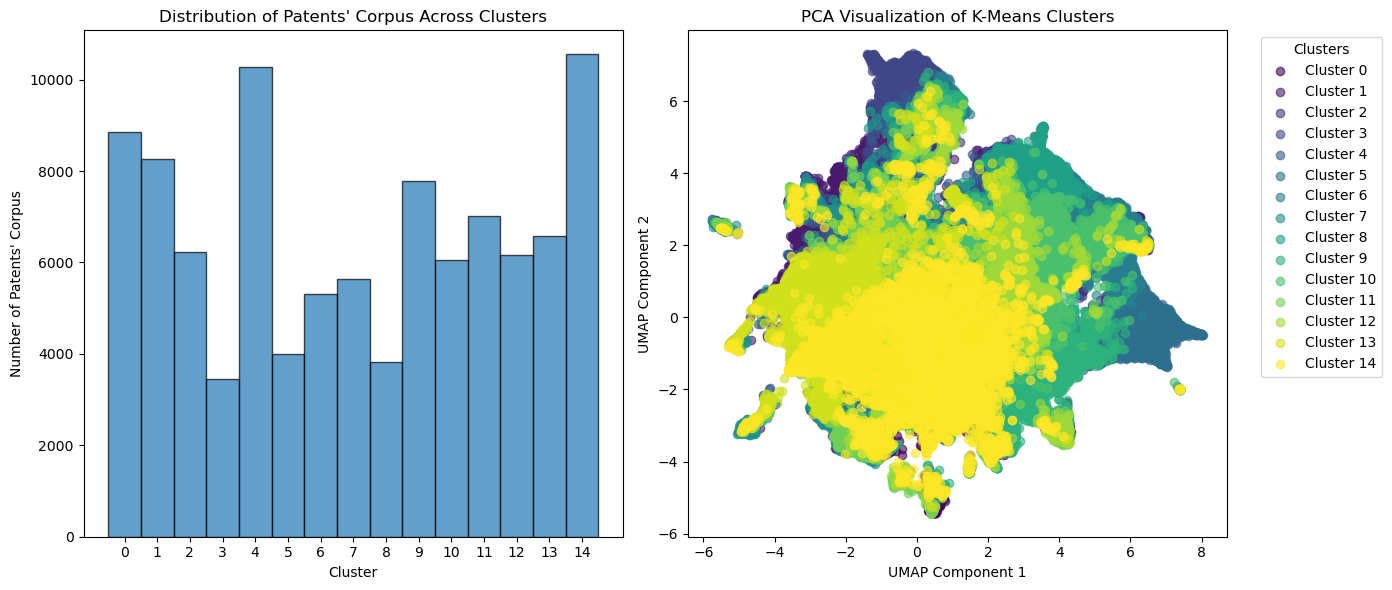

Cluster 0: side, one, adjacent, wall, strip, flange, pair, rail, overlapping, bottom
Cluster 1: one, movable, gear, actuating, carried, engaging, mechanism, carrier, moving, adjacent
Cluster 2: adjacent, one, side, wall, plurality, bottom, pair, therein, supporting, comprising
Cluster 3: circuit, switch, one, magnet, contact, armature, current, signal, second, element
Cluster 4: one, side, fixedportion, upon, slide, roller, pin, latter, grippersa, gear
Cluster 5: chemically, process, dissolving, solution, oxidized, toluene, sulphide, saponifying, phosphorus, lampblack
Cluster 6: water, air, gas, passage, liquid, outlet, flue, steam, furnace, wall
Cluster 7: side, one, pin, locking, hook, latch, slot, bolt, engage, latter
Cluster 8: piston, port, passage, inlet, one, exhaust, air, fluid, outlet, pressure
Cluster 9: side, one, sheet, strip, piece, material, metal, fabric, surface, blank
Cluster 10: bottom, side, top, one, wall, starchreceptacle, passage, cover, box, heaterplate
Cluster 1

In [13]:
df_clusters, cluster_keywords = k_means(X_word2vec, 15, df, False, word2vec_model= word2vec_model)

### Variations: K-Means ++
Instead of picking the centroids randomly, K-Means++ picks the first centroid randomly, and then it selects each next centroid probabilistically (higher probability to points that are farther away from already chosen centroids).

This ensures a good spread of initial centroids, reducing the chances of poor local minima.

K-Means converged in 85 iterations.


/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


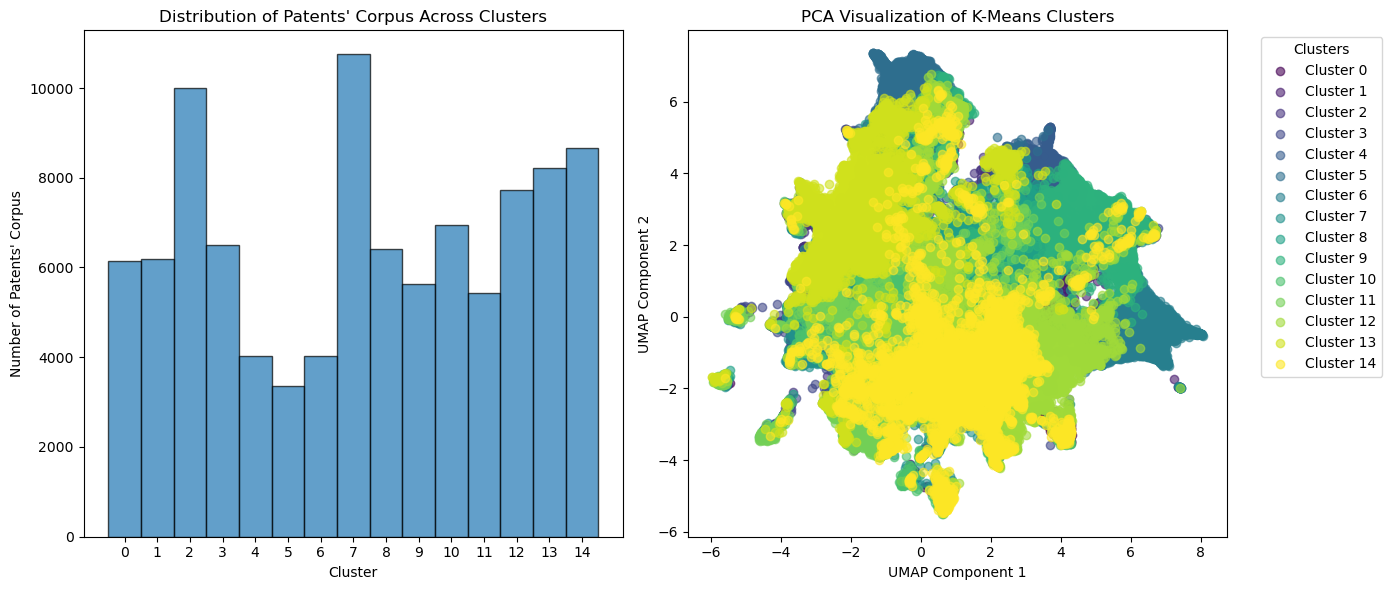

Cluster 0: side, flange, one, ring, wall, adjacent, face, recess, bolt, bottom
Cluster 1: bottom, side, top, one, wall, starchreceptacle, passage, cover, box, heaterplate
Cluster 2: one, side, fixedportion, upon, slide, pin, roller, latter, grippersa, gear
Cluster 3: side, one, supporting, support, adjacent, pair, rear, pivotally, connecting, carried
Cluster 4: piston, port, passage, inlet, one, exhaust, air, outlet, fluid, pressure
Cluster 5: circuit, switch, one, magnet, contact, armature, current, signal, second, element
Cluster 6: chemically, process, dissolving, solution, oxidized, sulphide, toluene, saponifying, phosphorus, lampblack
Cluster 7: side, one, piece, top, bolt, part, two, front, loop, hook
Cluster 8: one, adjacent, side, plurality, wall, pair, supporting, comprising, element, support
Cluster 9: water, air, gas, passage, liquid, outlet, flue, steam, furnace, wall
Cluster 10: side, one, adjacent, engaging, pair, locking, supporting, clamping, support, face
Cluster 11: s

In [14]:
df_clusters_plus, cluster_keywords = k_means(X_word2vec, 15, df, True, word2vec_model=word2vec_model)

df_clusters["Keywords"] = df_clusters["Cluster"].map(cluster_keywords)
df_clusters_plus[["patent_id", "Cluster"]].sort_values(by="Cluster").to_csv("data/clusters_word2vec.csv", index=False)

### UMAP and K-Means++

/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/z3/q3dm3kvj43q24611cgswtyph0000gp/T/ipykernel_99062/1565216796.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')


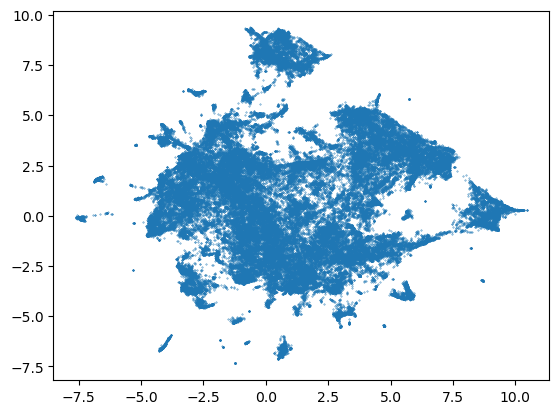

In [32]:
X_umap = umap.UMAP(n_neighbors = 5, min_dist = 0, n_components = 2, random_state=42).fit_transform(X_word2vec)
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')

K-Means converged in 45 iterations.


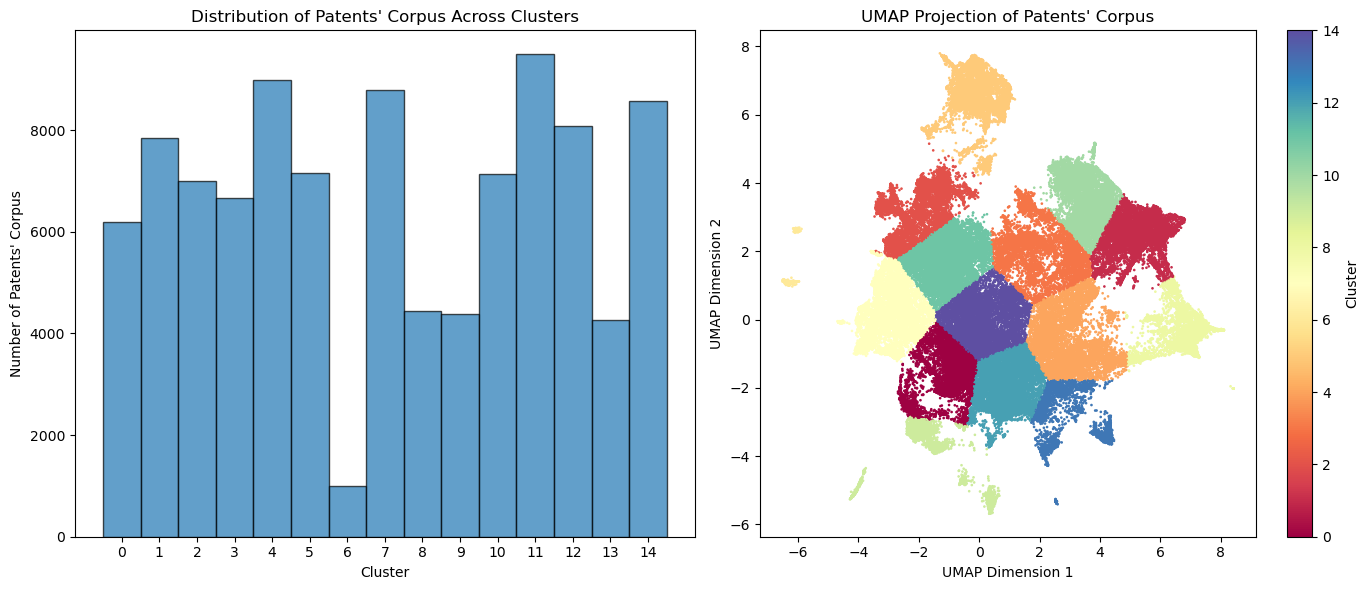

In [16]:
df_clusters_umap = k_means(X_umap, 15, df, True)

### UMAP and HDBSCAN

The concept of this algorithm is that it groups points that are closely packed together while marking points in low-density regions as noise. Then, it builds a minimum spanning tree (MST) of the data points, where the edges represent distances.

This MST is then used to construct a hierarchy of clusters by progressively removing the longer edges. This produces a hierarchical tree of clusters instead of a single clustering solution. 

It then transforms the hierarchical tree into a condensed tree, where each cluster is assigned a "stability" score, which is determined by how persistent a cluster remains at different levels of the hierarchy. Finally, it automatically selects the most stable clusters, leading to a more robust clustering solution.

- **min_samples** : provide a measure of how conservative you want your clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas

/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


There are 30 different clusters.
There are 28065 unclassified patents.


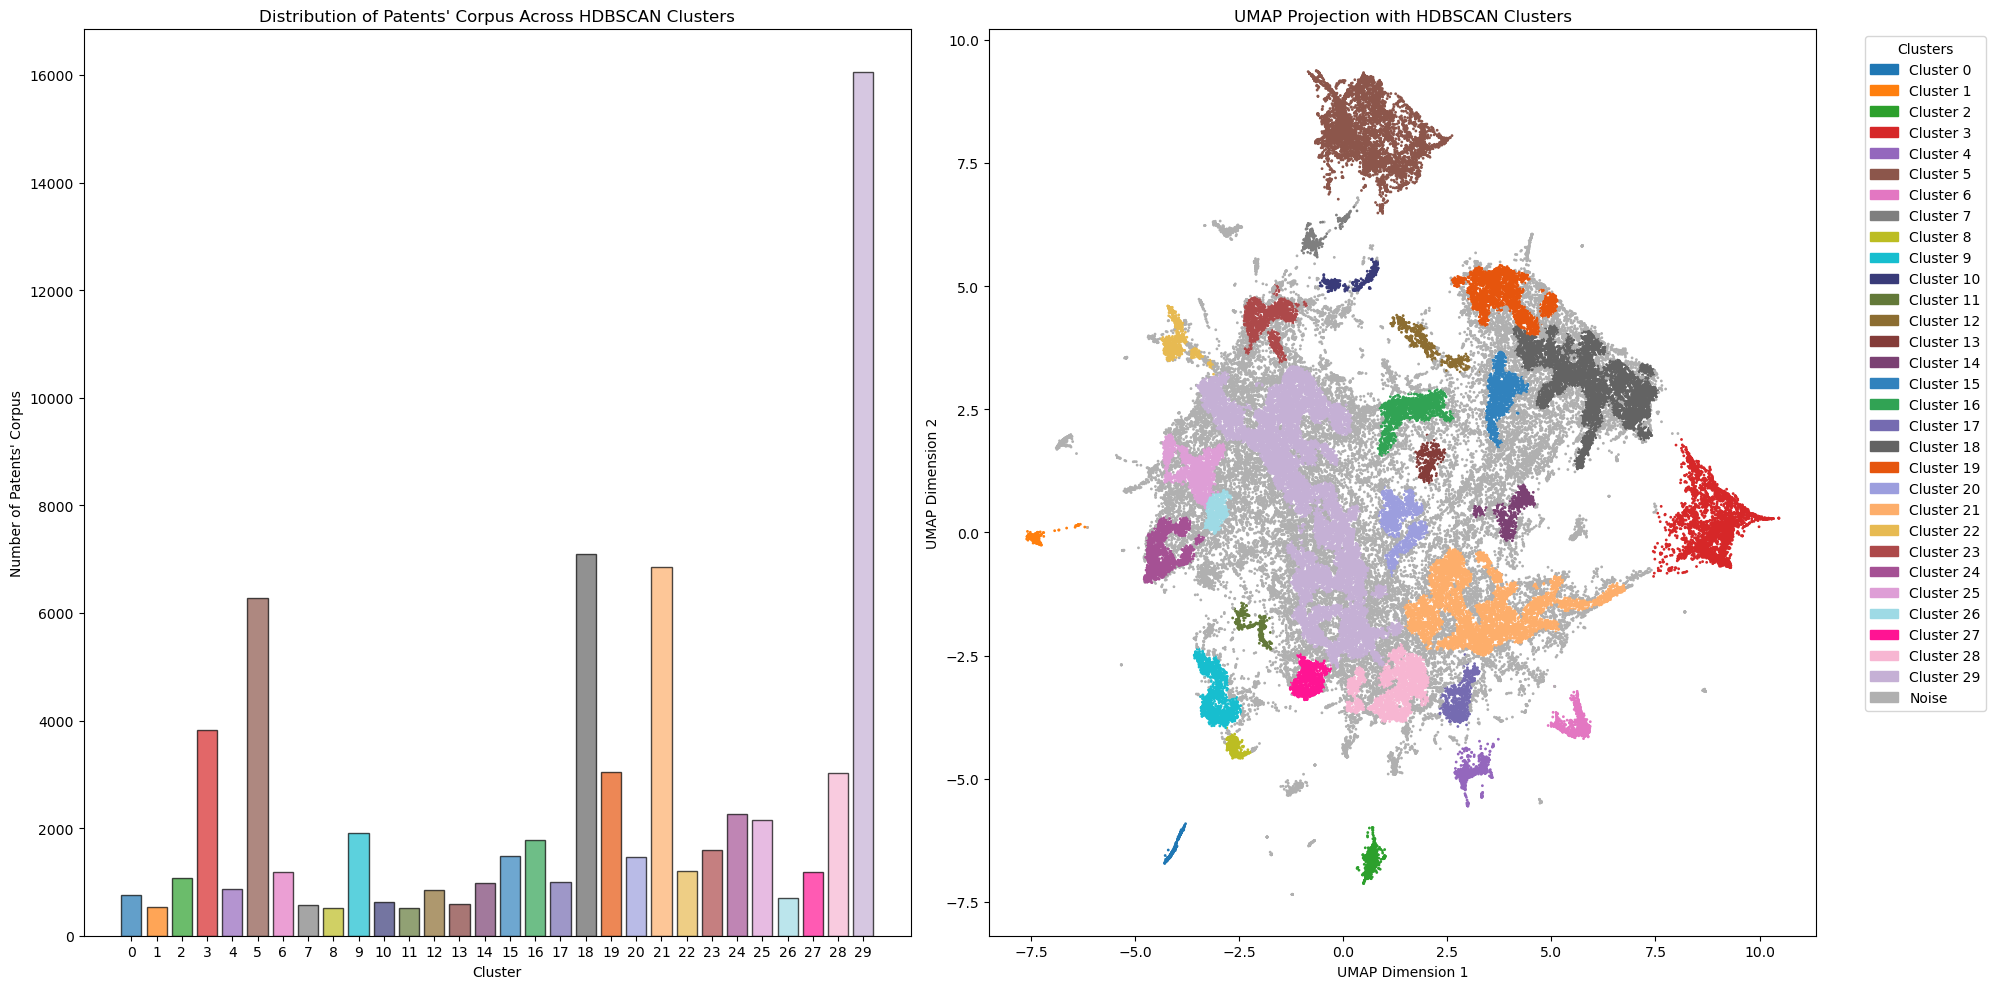

In [ ]:
import matplotlib.patches as mpatches

np.random.seed(42)

# HDBSCAN clustering on the UMAP data
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=90) #cluster_selection_epsilon=0.1)
labels_hdbscan = clusterer.fit_predict(X_umap)

df_clusters_hdbscan = pd.DataFrame({
        "patent_id": df["patent_id"],
        "Cluster": labels_hdbscan
    })

num_clusters = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
print(f"There are {num_clusters} different clusters.")

invalid_points = labels_hdbscan[labels_hdbscan == -1]
print(f"There are {len(invalid_points)} unclassified patents.")

distinct_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
    "#3182bd", "#31a354", "#756bb1", "#636363", "#e6550d",
    "#9c9ede", "#fdae6b", "#e7ba52", "#ad494a", "#a55194",
    "#de9ed6", "#9edae5", "#ff1493", "#f7b6d2", "#c5b0d5"
]

valid_labels = labels_hdbscan[labels_hdbscan != -1]
unique_clusters = np.sort(np.unique(valid_labels))
n_unique = len(unique_clusters)

if n_unique > len(distinct_colors):
    raise ValueError("Not enough distinct colors defined for the number of clusters.")

color_map = {cluster: distinct_colors[i] for i, cluster in enumerate(unique_clusters)}
noise_color = "#B0B0B0"  # light gray
point_colors = np.array([color_map[label] if label != -1 else noise_color for label in labels_hdbscan])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

if len(valid_labels) > 0:
    cluster_counts = pd.Series(valid_labels).value_counts().sort_index()
    bar_colors = [color_map[label] for label in cluster_counts.index]
    axes[0].bar(cluster_counts.index.astype(str), cluster_counts.values,
                color=bar_colors, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Number of Patents' Corpus")
    axes[0].set_title("Distribution of Patents' Corpus Across HDBSCAN Clusters")
else:
    axes[0].text(0.5, 0.5, 'No valid clusters',
                 horizontalalignment='center', verticalalignment='center')

scatter = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=point_colors, s=1)
axes[1].set_title("UMAP Projection with HDBSCAN Clusters")
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")

legend_handles = []
for cluster in unique_clusters:
    patch = mpatches.Patch(color=color_map[cluster], label=f"Cluster {cluster}")
    legend_handles.append(patch)
if -1 in labels_hdbscan:
    legend_handles.append(mpatches.Patch(color=noise_color, label="Noise"))
axes[1].legend(handles=legend_handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [43]:
def top_words_for_patent(X_tfidf, index, vectorizer, top_n=10):
    row = X_tfidf[index]
    feature_names = np.array(vectorizer.get_feature_names_out())
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-top_n:][::-1]
    return feature_names[top_indices]

corpus_tf = list_of_strings = [' '.join(words) for words in corpus_cleaned]
vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = vectorizer_tf_idf.fit_transform(corpus_tf)

##### Ranking by Membership Strength to the Cluster

In each cluster, which patents are the most important ? The ones that "match" the cluster the most ? 

To respond, I first use the probabilities_ attribute of HDBSCAN, which computes a membership strength for each point (between 0 and 1), representing how strongly the point belongs to its cluster.

In [44]:
def rank_patents_by_membership_strength(df, labels, probabilities, X_tfidf, vectorizer):
    df_copy = df.copy()
    df_copy["Cluster"] = labels
    df_copy["MembershipStrength"] = probabilities

    # Add top words per patent
    top_words_all = []
    for idx in df_copy.index:
        if df_copy.loc[idx, "Cluster"] == -1:
            top_words_all.append("") 
        else:
            top_words = top_words_for_patent(X_tfidf, idx, vectorizer)
            top_words_all.append(", ".join(top_words))
    
    df_copy["TopWords"] = top_words_all

    return df_copy

In [45]:
ranked_by_strength_df = rank_patents_by_membership_strength(df, labels_hdbscan, clusterer.probabilities_, X_tfidf, vectorizer_tf_idf)
ranked_by_strength_df = ranked_by_strength_df[["patent_id", "Cluster", "MembershipStrength", "TopWords"]].sort_values(by=["Cluster", "MembershipStrength"], ascending=[True, False])

for cluster_id in ranked_by_strength_df["Cluster"].unique():
    cluster_df = ranked_by_strength_df[ranked_by_strength_df["Cluster"] == cluster_id].head(5)

    print(f"\nCluster {cluster_id}")
    for _, row in cluster_df.iterrows():
        print(f"\nPatent ID: {row['patent_id']}")
        print(f"Membership Strength: {row['MembershipStrength']:.4f}")
        print(f"Top Words: {row['TopWords']}")

ranked_by_strength_df.to_csv("data/membership_hdbscan_w2v.csv", index = False)


Cluster -1

Patent ID: 709987
Membership Strength: 0.0000
Top Words: 

Patent ID: 691704
Membership Strength: 0.0000
Top Words: 

Patent ID: 323433
Membership Strength: 0.0000
Top Words: 

Patent ID: 1357490
Membership Strength: 0.0000
Top Words: 

Patent ID: 851111
Membership Strength: 0.0000
Top Words: 

Cluster 0

Patent ID: 521094
Membership Strength: 1.0000
Top Words: drawhead, knuckle, jaw, car, hook, flared, coupler, safety, hole, chambered

Patent ID: 566650
Membership Strength: 1.0000
Top Words: drawhead, link, block, pin, forwardly, toe, rocked, couplinglink, wall, couplingpin

Patent ID: 221797
Membership Strength: 1.0000
Top Words: beak, drawhead, link, car, drawheads, lockingbar, pendent, coupling, handlever, raised

Patent ID: 745794
Membership Strength: 1.0000
Top Words: link, hook, coupling, tumbler, car, automatic, pivoted, bracket, uncoupled, railwaycar

Patent ID: 116801
Membership Strength: 1.0000
Top Words: trigger, coupling, couplingbar, car, bolt, projection, li